# Final Project

## TRAC2- Transformer Models (BERT) - base uncased

In this section we build a BERT (Bidirectional Encoder Representations from Transformers) model.

We build two models: 
- Model for classification task A
- Model for classification task B

In [190]:
# mount drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Package imports

In [191]:
!pip install transformers

In [192]:
!pip install datasets

In [193]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

import tensorflow as tf
from transformers import AutoTokenizer
from transformers import TFAutoModelForSequenceClassification
from datasets import load_dataset

from sklearn.preprocessing import label_binarize
from sklearn import metrics

## Helper functions

In [194]:
def from_logits_to_labels(pred, task):
    '''
    Returns labels based on predicted logits on labels [CAG,NAG,OAG] for task A. Task B is binary, and 'GEN' represents 
    the positive class.
    Parameters:
    pred: array with model prediction
    task: either 'A' or 'B'
    '''
    index_a = {0:'CAG', 1:'NAG', 2:'OAG'}
    index_b = {0:'GEN', 1:'NGEN'}
    
    if task == 'A':
        highest_prob_class = np.argmax(pred, axis=1)
        labels = np.vectorize(index_a.get)(highest_prob_class.astype(int))
        
    elif task == 'B':
        highest_prob_class = np.argmax(pred, axis=1)
        labels = np.vectorize(index_b.get)(highest_prob_class.astype(int))
    else:
        labels = []
        
    return labels  

In [195]:
def to_one_hot_labels(string_labels):
    '''
    Returns one-hot encoded labels from a multi-class label vector e.g. ['cat', 'dog', 'dog', 'lion', 'cat', ...] 
    Parameters:
    string_labels: 
    '''
    labels = pd.get_dummies(string_labels)
    labels = labels.to_numpy()
    
    return labels

In [196]:
# this is modified to get the prediction as parameter
# to avoid predicting again since inference takes time
def confusion_matrix_plot(pred_labels, true_labels, task, normalize=None):
    '''
    Returns a confusion matrix with a nice format.
    Parameters:
    pred_labels: predicted labels
    true_labels: true labels 
    task: 'A' or 'B'
    normalize: if want to normalize the confusion matrix normalize='true'
    '''
    
    # Create a confusion matrix
    cm = metrics.confusion_matrix(true_labels, pred_labels, normalize=normalize)
    cm = np.around(cm, 2)

    # Plot the confusion matrix
    if task == 'A':
        axis_labels = ['CAG', 'NAG', 'OAG']
    elif task == 'B':
        axis_labels = ['GEN', 'NGEN']

    fig, ax = plt.subplots(figsize=(4,4))
    im = ax.imshow(cm, cmap="Blues")

    # Create the ticks and labels
    ax.set_xticks(np.arange(len(axis_labels)))
    ax.set_yticks(np.arange(len(axis_labels)))
    ax.set_xticklabels(axis_labels)
    ax.set_yticklabels(axis_labels)

    # Axis titles
    plt.ylabel('True label', size=12)
    plt.xlabel('Predicted label', size=12)

    # Loop over data dimensions and create text annotations.
    for i in range(len(axis_labels)):
        for j in range(len(axis_labels)):
            text = ax.text(j, i, cm[i, j],ha="center", va="center", color="dimgrey", size=12)
    
    ax.set_title("Confusion Matrix", size=16, weight="bold")
    fig.tight_layout()
    plt.show()


In [197]:
def loss_accuracy_plots(training_history, xrange, task):
    '''
    Returns plots for loss and accuracy during the training process of a NN.
    Parameters:
    training_history: object that stores the training history of the NN (from model.fit(...))
    xrange: range in x axis
    task: string used for the title in the plot
    '''
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))
    
    # loss plot
    ax1.plot(training_history.history['loss'], color='black')
    ax1.plot(training_history.history['val_loss'], color='blue')
    ax1.set_title('Training and validation loss Sub-Task ' + task)
    ax1.legend(['training', 'development'])
    ax1.grid(which='both')
    ax1.set_xticks(np.arange(0, xrange, 2))
    
    # accuracy plot
    ax2.plot(training_history.history['categorical_accuracy'], color='black')
    ax2.plot(training_history.history['val_categorical_accuracy'], color='blue')
    ax2.set_title('Training and validation acccuracy Sub_Task ' + task)
    ax2.legend(['training', 'development'])
    ax2.grid(which='both')
    ax2.set_xticks(np.arange(0, xrange, 2))
    plt.show()
    

## Load data
Load training, development and test datasets.

In [198]:
# Load labels using pandas dataframes

train_labels_a = pd.read_csv('drive/MyDrive/w266/release-files/eng/trac2_eng_train.csv')['Sub-task A']
train_labels_b = pd.read_csv('drive/MyDrive/w266/release-files/eng/trac2_eng_train.csv')['Sub-task B']
dev_labels_a = pd.read_csv('drive/MyDrive/w266/release-files/eng/trac2_eng_dev.csv')['Sub-task A']
dev_labels_b = pd.read_csv('drive/MyDrive/w266/release-files/eng/trac2_eng_dev.csv')['Sub-task B']
test_labels_a = pd.read_csv('drive/MyDrive/w266/release-files/gold/trac2_eng_gold_a.csv')['Sub-task A']
test_labels_b = pd.read_csv('drive/MyDrive/w266/release-files/gold/trac2_eng_gold_b.csv')['Sub-task B']

In [199]:
# Load text data using Hugging Face datasets
# need to use the split argument even though we are not splitting. If not, data is loaded as DatasetDict
# to load as dataset need to include the split parameter
train_dataset = load_dataset('csv', data_files='drive/MyDrive/w266/release-files/eng/trac2_eng_train.csv', split = 'train[:4263]')
dev_dataset = load_dataset('csv', data_files='drive/MyDrive/w266/release-files/eng/trac2_eng_dev.csv', split = 'train[:1066]')
test_dataset = load_dataset('csv', data_files='drive/MyDrive/w266/release-files/test/trac2_eng_test.csv', split = 'train[:1200]')

Using custom data configuration default-dcbea4a4746f37c7
Reusing dataset csv (/root/.cache/huggingface/datasets/csv/default-dcbea4a4746f37c7/0.0.0/bf68a4c4aefa545d0712b2fcbb1b327f905bbe2f6425fbc5e8c25234acb9e14a)
Using custom data configuration default-98e2ce082b0629f1
Reusing dataset csv (/root/.cache/huggingface/datasets/csv/default-98e2ce082b0629f1/0.0.0/bf68a4c4aefa545d0712b2fcbb1b327f905bbe2f6425fbc5e8c25234acb9e14a)
Using custom data configuration default-0ba61447556c92da
Reusing dataset csv (/root/.cache/huggingface/datasets/csv/default-0ba61447556c92da/0.0.0/bf68a4c4aefa545d0712b2fcbb1b327f905bbe2f6425fbc5e8c25234acb9e14a)


## Encode labels

In [200]:
# encode labels Task A- [CAG,NAG,OAG]
train_labels_a_enc = to_one_hot_labels(train_labels_a)
dev_labels_a_enc = to_one_hot_labels(dev_labels_a)
test_labels_a_enc = to_one_hot_labels(test_labels_a)


In [201]:
# encode labels Task B- [GEN, NGEN]
train_labels_b_enc = to_one_hot_labels(train_labels_b)
dev_labels_b_enc = to_one_hot_labels(dev_labels_b)
test_labels_b_enc = to_one_hot_labels(test_labels_b)

## Prepare TensorFlow datasets for BERT

In [202]:
# remove columns to leave only the column with the posts. Column 'Text'
train_dataset = train_dataset.remove_columns(['ID', 'Sub-task B', 'Sub-task A'])
dev_dataset = dev_dataset.remove_columns(['ID', 'Sub-task A', 'Sub-task B'])
test_dataset = test_dataset.remove_columns('ID')

In [203]:
# define a BERT tokenizer
# use the bert-based-uncased tokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

In [204]:
# test how the tokenizer works
test_sentence = 'I REALLY want to take some vacations soon'
test_sentence

'I REALLY want to take some vacations soon'

In [205]:
encoded_input = tokenizer(test_sentence)
encoded_input

{'input_ids': [101, 1045, 2428, 2215, 2000, 2202, 2070, 10885, 2015, 2574, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [206]:
tokenizer.decode(encoded_input['input_ids'])

'[CLS] i really want to take some vacations soon [SEP]'

The tokenizer automatically lowercase the input text, and ads some special tokens ([CLS] and [SEP]) that the BERT model expects.

To use the training examples in the model we need to pad (or truncate) each example to a maximum lenght. For BERT the maximum possible length is 512. 

In [207]:
# tokenize the train, development and test data
# Use a max sequence of 150 tokens. Based on EDA this is enough for majority of posts

train_dataset_tok = train_dataset.map(lambda x: tokenizer(x['Text'], truncation=True, padding=True, max_length=150), batched=True)
dev_dataset_tok = dev_dataset.map(lambda x: tokenizer(x['Text'], truncation=True, padding=True, max_length=150), batched=True)
test_dataset_tok = test_dataset.map(lambda x: tokenizer(x['Text'], truncation=True, padding=True, max_length=150), batched=True)

Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/default-dcbea4a4746f37c7/0.0.0/bf68a4c4aefa545d0712b2fcbb1b327f905bbe2f6425fbc5e8c25234acb9e14a/cache-c923529c66d5ccab.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/default-98e2ce082b0629f1/0.0.0/bf68a4c4aefa545d0712b2fcbb1b327f905bbe2f6425fbc5e8c25234acb9e14a/cache-73d85db1f8d99afd.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/default-0ba61447556c92da/0.0.0/bf68a4c4aefa545d0712b2fcbb1b327f905bbe2f6425fbc5e8c25234acb9e14a/cache-4c20c811dcaf9cd3.arrow


In [208]:
# now we can remove the column with the original post from the dataset. We are going to use the result of tokenization for modeling
train_dataset_tok = train_dataset_tok.remove_columns(['Text']).with_format('tensorflow')
dev_dataset_tok = dev_dataset_tok.remove_columns(['Text']).with_format('tensorflow')
test_dataset_tok = test_dataset_tok.remove_columns(['Text']).with_format('tensorflow')

In [209]:
# extract features from tokenizer output: 'input_ids', 'token_type_ids', 'attention_mask'
train_features = {x: train_dataset_tok[x] for x in tokenizer.model_input_names}
dev_features = {x: dev_dataset_tok[x] for x in tokenizer.model_input_names}
test_features = {x: test_dataset_tok[x] for x in tokenizer.model_input_names}

In [210]:
# batch data

batch_size = 16
buffer = len(train_dataset_tok)

# Task A
train_tf_dataset_a = tf.data.Dataset.from_tensor_slices((train_features, train_labels_a_enc)).shuffle(buffer).batch(batch_size)
dev_tf_dataset_a = tf.data.Dataset.from_tensor_slices((dev_features, dev_labels_a_enc)).batch(batch_size)
test_tf_dataset_a = tf.data.Dataset.from_tensor_slices((test_features, test_labels_a_enc)).batch(batch_size)

# Task B
train_tf_dataset_b = tf.data.Dataset.from_tensor_slices((train_features, train_labels_b_enc)).shuffle(buffer).batch(batch_size)
dev_tf_dataset_b = tf.data.Dataset.from_tensor_slices((dev_features, dev_labels_b_enc)).batch(batch_size)
test_tf_dataset_b = tf.data.Dataset.from_tensor_slices((test_features, test_labels_b_enc)).batch(batch_size)

## Model Task A

In [211]:
# delete model if exists
try:
    del BERT_model_A
except:
    pass

In [212]:
# define the model. Task A is a classification task with 3 labels
BERT_model_A = TFAutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [213]:
# compile model
BERT_model_A.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
                     loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                     metrics=tf.metrics.CategoricalAccuracy()
                    )

In [214]:
# fit model
training_history = BERT_model_A.fit(train_tf_dataset_a, validation_data=dev_tf_dataset_a, epochs=2)

Epoch 1/2
267/267 [==============================] - 114s 373ms/step - loss: 0.5423 - categorical_accuracy: 0.7933 - val_loss: 0.4833 - val_categorical_accuracy: 0.7842
Epoch 2/2
267/267 [==============================] - 97s 364ms/step - loss: 0.4010 - categorical_accuracy: 0.8285 - val_loss: 0.4735 - val_categorical_accuracy: 0.8011


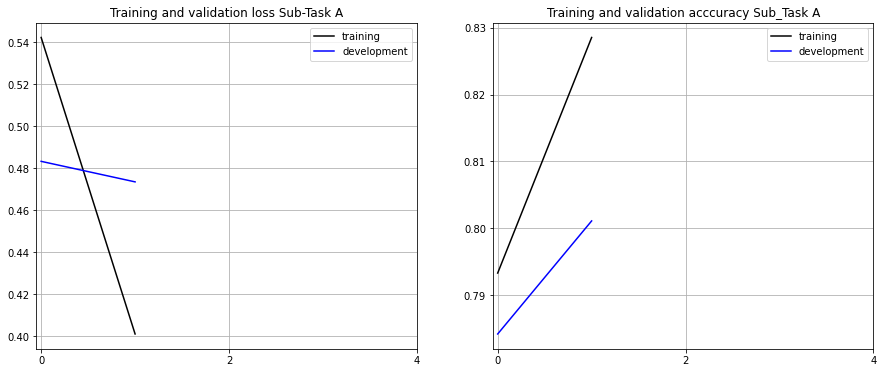

In [215]:
# plot loss and accuracy
loss_accuracy_plots(training_history, xrange=5, task='A')

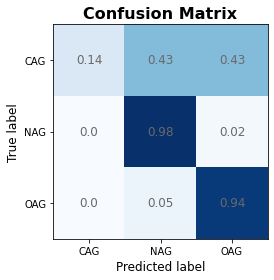

              precision    recall  f1-score   support

         CAG      0.956     0.143     0.250       453
         NAG      0.939     0.982     0.960      3375
         OAG      0.618     0.945     0.747       435

    accuracy                          0.889      4263
   macro avg      0.838     0.690     0.652      4263
weighted avg      0.908     0.889     0.863      4263

Weighted f1-score: 0.8627035526443589


In [216]:
# Evaluate model on TRAINING data

# predict using model. Returns logits
pred_labels_train = BERT_model_A.predict(train_features)[0]

# convert logits lo labels
pred_labels_train = from_logits_to_labels(pred_labels_train, 'A')

# confusion matrix
confusion_matrix_plot(pred_labels_train, train_labels_a, task='A', normalize='true')

# print the precision, recall, f1
print(metrics.classification_report(train_labels_a, pred_labels_train, digits=3))

# print global weighted f-1 score
print(f"Weighted f1-score: {metrics.f1_score(train_labels_a, pred_labels_train, pos_label=1, average='weighted')}")


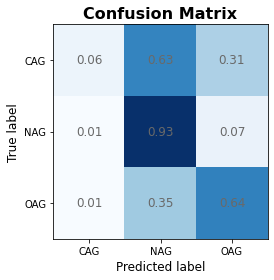

              precision    recall  f1-score   support

         CAG      0.538     0.060     0.108       117
         NAG      0.872     0.927     0.899       836
         OAG      0.439     0.637     0.520       113

    accuracy                          0.801      1066
   macro avg      0.616     0.541     0.509      1066
weighted avg      0.789     0.801     0.772      1066

Weighted f1-score: 0.7716060864048507


In [217]:
# Evaluate model on DEVELOPMENT data

# predict using model. Returns logits
pred_labels_dev = BERT_model_A.predict(dev_features)[0]

# convert logits lo labels
pred_labels_dev = from_logits_to_labels(pred_labels_dev, 'A')

# confusion matrix
confusion_matrix_plot(pred_labels_dev, dev_labels_a, task='A', normalize='true')

# print the precision, recall, f1
print(metrics.classification_report(dev_labels_a, pred_labels_dev, digits=3))

# print global weighted f-1 score
print(f"Weighted f1-score: {metrics.f1_score(dev_labels_a, pred_labels_dev, pos_label=1, average='weighted')}")

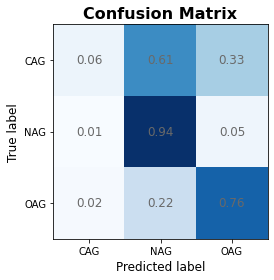

              precision    recall  f1-score   support

         CAG      0.560     0.062     0.112       224
         NAG      0.766     0.941     0.845       690
         OAG      0.662     0.759     0.707       286

    accuracy                          0.733      1200
   macro avg      0.663     0.587     0.555      1200
weighted avg      0.703     0.733     0.675      1200

Weighted f1-score: 0.6750430650452431


In [218]:
# Evaluate model on TEST data

# predict using model. Returns logits
pred_labels_test = BERT_model_A.predict(test_features)[0]

# convert logits lo labels
pred_labels_test = from_logits_to_labels(pred_labels_test, 'A')

# confusion matrix
confusion_matrix_plot(pred_labels_test, test_labels_a, task='A', normalize='true')

# print the precision, recall, f1
print(metrics.classification_report(test_labels_a, pred_labels_test, digits=3))

# print global weighted f-1 score
print(f"Weighted f1-score: {metrics.f1_score(test_labels_a, pred_labels_test, pos_label=1, average='weighted')}")

In [219]:
# save model
BERT_model_A.save_pretrained('drive/MyDrive/w266/saved_models/TRAC-2_BERT_model_A')

## Model Task B

In [31]:
# delete model if exists
try:
    del BERT_model_B
except:
    pass

In [32]:
# define the model. Task B is a classification task with 2 labels
BERT_model_B = TFAutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [33]:
# compile model
BERT_model_B.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
                     loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                     metrics=tf.metrics.CategoricalAccuracy()
                    )

In [34]:
# fit model
training_history = BERT_model_B.fit(train_tf_dataset_b, validation_data=dev_tf_dataset_b, epochs=3)

Epoch 1/3
267/267 [==============================] - 114s 372ms/step - loss: 0.2048 - categorical_accuracy: 0.9324 - val_loss: 0.1794 - val_categorical_accuracy: 0.9475
Epoch 2/3
267/267 [==============================] - 97s 363ms/step - loss: 0.1139 - categorical_accuracy: 0.9604 - val_loss: 0.1676 - val_categorical_accuracy: 0.9428
Epoch 3/3
267/267 [==============================] - 97s 363ms/step - loss: 0.0572 - categorical_accuracy: 0.9805 - val_loss: 0.2201 - val_categorical_accuracy: 0.9428


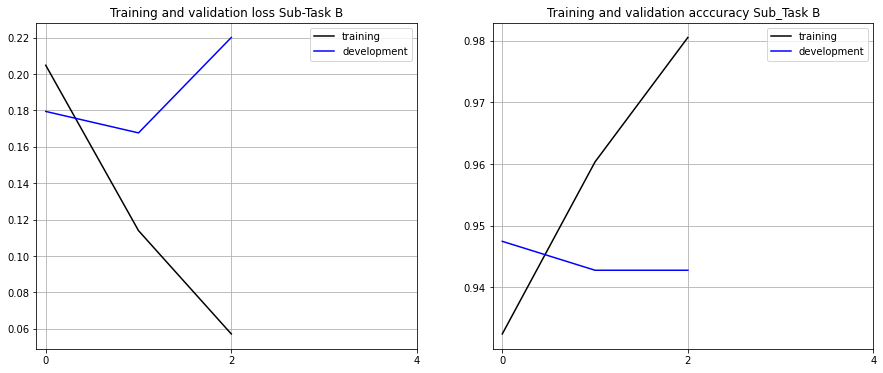

In [35]:
# plot loss and accuracy
loss_accuracy_plots(training_history, xrange=5, task='B')

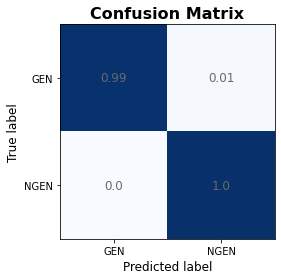

              precision    recall  f1-score   support

         GEN      0.968     0.994     0.981       309
        NGEN      0.999     0.997     0.998      3954

    accuracy                          0.997      4263
   macro avg      0.984     0.995     0.990      4263
weighted avg      0.997     0.997     0.997      4263

Weighted f1-score: 0.9972016423567739


In [36]:
# Evaluate model on TRAINING data

# predict using model. Returns logits
pred_labels_train = BERT_model_B.predict(train_features)[0]

# convert logits lo labels
pred_labels_train = from_logits_to_labels(pred_labels_train, 'B')

# confusion matrix
confusion_matrix_plot(pred_labels_train, train_labels_b, task='B', normalize='true')

# print the precision, recall, f1
print(metrics.classification_report(train_labels_b, pred_labels_train, digits=3))

# print global weighted f-1 score
print(f"Weighted f1-score: {metrics.f1_score(train_labels_b, pred_labels_train, pos_label=1, average='weighted')}")


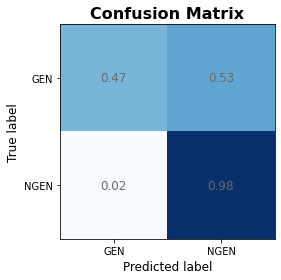

              precision    recall  f1-score   support

         GEN      0.607     0.466     0.527        73
        NGEN      0.961     0.978     0.970       993

    accuracy                          0.943      1066
   macro avg      0.784     0.722     0.748      1066
weighted avg      0.937     0.943     0.939      1066

Weighted f1-score: 0.9392490448991346


In [37]:
# Evaluate model on DEVELOPMENT data

# predict using model. Returns logits
pred_labels_dev = BERT_model_B.predict(dev_features)[0]

# convert logits lo labels
pred_labels_dev = from_logits_to_labels(pred_labels_dev, 'B')

# confusion matrix
confusion_matrix_plot(pred_labels_dev, dev_labels_b, task='B', normalize='true')

# print the precision, recall, f1
print(metrics.classification_report(dev_labels_b, pred_labels_dev, digits=3))

# print global weighted f-1 score
print(f"Weighted f1-score: {metrics.f1_score(dev_labels_b, pred_labels_dev, pos_label=1, average='weighted')}")

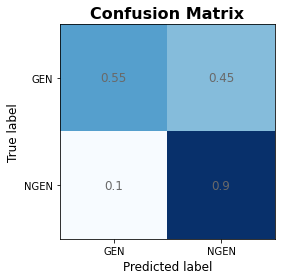

              precision    recall  f1-score   support

         GEN      0.497     0.554     0.524       175
        NGEN      0.922     0.904     0.913      1025

    accuracy                          0.853      1200
   macro avg      0.710     0.729     0.719      1200
weighted avg      0.860     0.853     0.857      1200

Weighted f1-score: 0.8565748014023876


In [38]:
# Evaluate model on TEST data

# predict using model. Returns logits
pred_labels_test = BERT_model_B.predict(test_features)[0]

# convert logits lo labels
pred_labels_test = from_logits_to_labels(pred_labels_test, 'B')

# confusion matrix
confusion_matrix_plot(pred_labels_test, test_labels_b, task='B', normalize='true')

# print the precision, recall, f1
print(metrics.classification_report(test_labels_b, pred_labels_test, digits=3))

# print global weighted f-1 score
print(f"Weighted f1-score: {metrics.f1_score(test_labels_b, pred_labels_test, pos_label=1, average='weighted')}")

In [39]:
# save model
BERT_model_B.save_pretrained('drive/MyDrive/w266/saved_models/TRAC-2_BERT_model_B')

## References

- Pre-processing data: https://huggingface.co/transformers/preprocessing.html

- Fine-tunning a pre-trained model: https://huggingface.co/transformers/training.html

- BERT: https://huggingface.co/transformers/model_doc/bert.html